In [1]:
# default_exp collation

# Outage Data Collation

<br>

### Imports

In [37]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd

from outage import retrieval

import matplotlib.pyplot as plt

import os
import requests
from warnings import warn

from ipypb import track
from IPython.display import JSON

In [3]:
#exports
def collate_cleaned_incidents_info(dnos=['ukpn', 'ssen', 'wpd']):
    cleaned_incidents_info = dict()

    for dno in track(dnos, label='DNOs'):
        raw_dno_incidents_info, cleaned_dno_incidents_info = getattr(retrieval, f'get_{dno}_incidents_info')()
        cleaned_incidents_info[dno] = cleaned_dno_incidents_info
        retrieval.save_json_data(raw_dno_incidents_info, f'{dno}_incidents_info')
        
    return cleaned_incidents_info

In [4]:
cleaned_incidents_info = collate_cleaned_incidents_info()

JSON([cleaned_incidents_info])

           DNOs [█████████████████████████████████████████████] 3/3 [00:17<00:01, 5.55s/it]

   Multiple Ids [█████████████████████████████████████████████] 4/4 [00:01<00:00, 0.26s/it]

        Details [█████████████████████████████████████████████] 55/55 [00:14<00:00, 0.25s/it]

C:\Users\Ayrto\anaconda3\envs\outage\lib\site-packages\urllib3\connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ssen.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


 [████████████████████████████████████████████████████████████] 3/3 [00:00<00:00, 0.00s/it]

<IPython.core.display.JSON object>

In [52]:
#exports
def get_combined_outages_df(cleaned_incidents_info):
    df_outages = pd.DataFrame()

    for dno, dno_outages in cleaned_incidents_info.items():
        df_dno_outages = pd.DataFrame(dno_outages).T.query('incident_active==True')

        df_dno_outages['dno'] = dno
        df_dno_outages = df_dno_outages[['received_time', 'estimated_restored_time', 'postcodes_impacted', 'description', 'dno', 'incident_url']]

        df_dno_outages.index.name = 'incident_id'
        df_dno_outages = df_dno_outages.reset_index()

        df_outages = df_outages.append(df_dno_outages)

    df_outages = df_outages.reset_index(drop=True)
    
    return df_outages

In [54]:
df_outages = get_combined_outages_df(cleaned_incidents_info)
    
df_outages.head(3)

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url
0,INCD-259361-J,2021-04-05T11:52:00,2021-04-05T21:00:00,"[NW10RE, NW19RE, NW19SG, NW19SH, NW10RG, NW19Q...",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
1,INCD-259364-J,2021-04-05T13:48:00,2021-04-05T20:00:00,"[N51XG, N51PR, N51PS, N51PT, N51XR]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...
2,INCD-247691-G,2021-04-04T02:05:00,None,"[BN11YE, UMS, BN11UA, BN11YA, BN14AB, BN14AD, ...",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...


<br>

### Locating Post Codes

In [10]:
%%time

df_postcodes = pd.read_csv('../data/postcodes.csv', index_col='postcode')
df_postcodes.index = df_postcodes.index.str.replace(' ', '')

df_postcodes.head()

Wall time: 3.89 s


,longitude,latitude
postcode,,
AB101AB,-2.096916,57.149606
AB101AF,-2.097806,57.148707
AB101AG,-2.096997,57.149067
AB101AH,-2.094664,57.148080
AB101AL,-2.095909,57.150074


<br>

Although most are, some post-codes aren't included in our database

In [11]:
check_postcode_is_in_df = lambda postcode, df: postcode in df.index

In [12]:
(check_postcode_is_in_df('W1M1HE', df_postcodes), 
 check_postcode_is_in_df('HP41FD', df_postcodes))

(False, True)

In [13]:
def get_postcode_location_df(df_postcodes, postcode):
    postcode_is_in_df = check_postcode_is_in_df(postcode, df_postcodes)
    
    if postcode_is_in_df:
        location = df_postcodes.loc[postcode]

        longitude = location['longitude']
        latitude = location['latitude']
        
    else:
        longitude, latitude = None, None

    return longitude, latitude

In [14]:
longitude, latitude = get_postcode_location_df(df_postcodes, 'HP41FD')

longitude, latitude

(-0.5676534391043929, 51.76118688537669)

In [15]:
get_postcode_url = lambda postcode: f'http://api.getthedata.com/postcode/{postcode}'

In [16]:
postcode = 'W1M1HE'

postcode_url = get_postcode_url(postcode)
r_json = requests.get(postcode_url).json()

JSON(r_json)

<IPython.core.display.JSON object>

In [30]:
def get_postcode_location_api(postcode):
    longitude, latitude = None, None
    
    postcode_url = get_postcode_url(postcode)
    r_json = requests.get(postcode_url).json()

    if r_json['status'] == 'match':
        data_keys = r_json['data'].keys()
        
        if 'longitude' in data_keys and 'latitude' in data_keys:
            longitude = float(r_json['data']['longitude'])
            latitude = float(r_json['data']['latitude'])

    return longitude, latitude

In [18]:
longitude, latitude = get_postcode_location_api(postcode)

longitude, latitude

(-0.155234, 51.519146)

In [19]:
#exports
class PostCodeLocator:
    def __init__(self, postcodes_fp: str='../data/postcodes.csv'):
        # Loading Post Codes DataFrame
        df_postcodes = pd.read_csv(postcodes_fp, index_col='postcode')
        df_postcodes.index = df_postcodes.index.str.replace(' ', '')
        
        self.df_postcodes = df_postcodes
        
    def get_postcode_location(self, postcode):
        postcode_is_in_df = check_postcode_is_in_df(postcode, self.df_postcodes)

        if postcode_is_in_df:
            longitude, latitude = get_postcode_location_df(self.df_postcodes, postcode)
            
        else:
            longitude, latitude = get_postcode_location_api(postcode)
            
        if longitude is None or latitude is None:
            warn(f'The longitude and latitude of {postcode} could not be determined')
            
        return longitude, latitude

In [31]:
%%time

pcl = PostCodeLocator()

Wall time: 4.34 s


In [21]:
%%time

postcode = 'HP41FD'

pcl.get_postcode_location(postcode)

Wall time: 856 ms


(-0.5676534391043929, 51.76118688537669)

In [22]:
%%time

postcode = 'W1M1HE'

pcl.get_postcode_location(postcode)

Wall time: 96 ms


(-0.155234, 51.519146)

<br>

### Creating Outages Leaflet GeoJSON

In [50]:
def add_outage_longitudes_latitudes(df_outages, postcodes_fp: str='../data/postcodes.csv'):
    pcl = PostCodeLocator(postcodes_fp)
        
    s_incident_longitudes = pd.Series(index=df_outages.index, dtype='float64')
    s_incident_latitudes = pd.Series(index=df_outages.index, dtype='float64')

    for outage_idx, s_outage in track(df_outages.iterrows(), total=df_outages.shape[0]):
        incident_longitudes = []
        incident_latitudes = []

        for postcode_impacted in s_outage['postcodes_impacted']:
            longitude, latitude = pcl.get_postcode_location(postcode_impacted)

            incident_longitudes += [longitude]
            incident_latitudes += [latitude]

        s_incident_longitudes.loc[outage_idx] = pd.Series(incident_longitudes).mean()
        s_incident_latitudes.loc[outage_idx] = pd.Series(incident_latitudes).mean()
        
    df_outages = (df_outages
                  .assign(longitude=s_incident_longitudes)
                  .assign(latitude=s_incident_latitudes)
                 )
    
    return df_outages

In [67]:
df_outages = add_outage_longitudes_latitudes(df_outages)

df_outages.head(3)

,incident_id,received_time,estimated_restored_time,postcodes_impacted,description,dno,incident_url,longitude,latitude
0,INCD-259361-J,2021-04-05T11:52:00,2021-04-05T21:00:00,"[NW10RE, NW19RE, NW19SG, NW19SH, NW10RG, NW19Q...",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.132014,51.543393
1,INCD-259364-J,2021-04-05T13:48:00,2021-04-05T20:00:00,"[N51XG, N51PR, N51PS, N51PT, N51XR]",A fault occurred on an underground electricity...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.105853,51.550313
2,INCD-247691-G,2021-04-04T02:05:00,None,"[BN11YE, UMS, BN11UA, BN11YA, BN14AB, BN14AD, ...",We had to turn off power in your area so our e...,ukpn,https://www.ukpowernetworks.co.uk/power-cut/ma...,-0.137029,50.825975


In [ ]:
# create a geojson and save it to github, then load from that for leaflet

<AxesSubplot:>

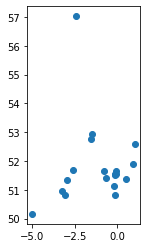

In [68]:
gdf_outages = gpd.GeoDataFrame(
    data=df_outages.drop(columns=['longitude', 'latitude']), 
    geometry=gpd.points_from_xy(df_outages['longitude'], df_outages['latitude']),
    crs='EPSG:4326'
)

gdf_outages.plot()

In [77]:
outages_geojson = json.loads(gdf_outages.to_json(drop_id=True))

with open('../data/outage_locations.json', 'w') as fp:
    json.dump(outages_geojson, fp)

JSON(outages_geojson)

<IPython.core.display.JSON object>